In [29]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import pandas as pd
from lightgbm import LGBMClassifier
import numpy as np

In [30]:
def compute_rolling_std(X_df, feature, time_window, center=True):
    """
    For a given dataframe, compute the standard deviation over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    X : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling std from
    time_window : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    name = "_".join([feature, time_window, "std", str(center)])
    X_df[name] = X_df[feature].rolling(time_window, center=center).std()
    X_df[name] = X_df[name].ffill().bfill()
    X_df[name] = X_df[name].astype(X_df[feature].dtype)
    return X_df

def compute_rolling_mean(X_df, feature, time_window, center=True):
    """
    For a given dataframe, compute the mean over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    X : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling mean from
    time_window : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    name = "_".join([feature, time_window, "mean", str(center)])
    X_df[name] = X_df[feature].rolling(time_window, center=center).mean()
    X_df[name] = X_df[name].ffill().bfill()
    X_df[name] = X_df[name].astype(X_df[feature].dtype)
    return X_df

def compute_rolling_median(X_df, feature, time_window, center=True):
    """
    For a given dataframe, compute the mean over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    X : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling mean from
    time_window : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    name = "_".join([feature, time_window, "median", str(center)])
    X_df[name] = X_df[feature].rolling(time_window, center=center).median()
    X_df[name] = X_df[name].ffill().bfill()
    X_df[name] = X_df[name].astype(X_df[feature].dtype)
    return X_df

def compute_rolling_variables(X_df, feature, time_window, center=True):
    X_df = compute_rolling_mean(X_df, feature, time_window, True)
    X_df = compute_rolling_std(X_df, feature, time_window, True)
    X_df = compute_rolling_mean(X_df, feature, time_window, False)
    X_df = compute_rolling_std(X_df, feature, time_window, False)
    return X_df


def compute_rolling_variables(X_df, feature, time_window, center=True):
    X_df = compute_rolling_mean(X_df, feature, time_window, True)
    X_df = compute_rolling_std(X_df, feature, time_window, True)
    X_df = compute_rolling_mean(X_df, feature, time_window, False)
    X_df = compute_rolling_std(X_df, feature, time_window, False)
    return X_df

def clip_column(X_df, column, min, max):
    X_df[column] = X_df[column].clip(min, max)
    return X_df

def smoothing(y, factor):
    i=0
    factor = factor
    while i < (y.shape[0]+1-factor):
        if y[:,0][range(i,i+factor)].mean() > 0.5:
            y[:,0][range(i,i+factor)] = 0.99 + 10**-15
            y[:,1][range(i,i+factor)] = 0.01 - 10**-15
        else:
            y[:,0][range(i,i+factor)] = 0.01 - 10**-15
            y[:,1][range(i,i+factor)] = 0.99 + 10**-15
        i+=factor
    return y

def smoothing2(y, factor):
    i=0
    factor = factor
    while i < (y.shape[0]+1-factor):
        y[:,0][range(i,i+factor)] = y[:,0][range(i,i+factor)].mean()
        y[:,1][range(i,i+factor)] = y[:,1][range(i,i+factor)].mean()
        i+=factor
    return y

def smoothingp(y, factor):
    i=0
    factor = 18
    while i < (y.shape[0]+1-factor):
        y[range(i, i+factor)] = 0
        i+=factor
    return y
    
def smoothingroll(y, factor):
    y2 = y.copy()
    i=factor
    factor = factor
    while i < (y.shape[0]+1-factor):
        y2[:,0][i] = (y[:,0][range(i-factor,i+factor)].mean())
        y2[:,1][i] = (y[:,1][range(i-factor,i+factor)].mean())
        i+=1
    return y2

def smoothingroll2(y, factor):
    kernel = np.ones(factor)/factor
    kernel = [1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1]

    kernel = 5*[1] + 5*[3] + 10*[5] + 5*[3] + 5*[1]
    kernel = (kernel/np.sum(kernel))
    y[:,0] = np.convolve(y[:,0], kernel, 'same')
    y[:,1] = np.convolve(y[:,1], kernel, 'same')
    return y
        
def smoothingroll3(y, factor, quantile):
    y = pd.DataFrame(y)
    y[1] = y[1].rolling(factor, min_periods=0, center=True).quantile(quantile)
    y[0] = 1-y[1].ffill().bfill()
    y = y.to_numpy()
    return y




def transform(X):
    X = clip_column(X, 'Beta', 0, 500)
    X = clip_column(X, "B", 0, 1000)
    X = clip_column(X, "RmsBob", 0, 20)
    X = clip_column(X, "Vth", 0, 200)
    X = clip_column(X, "Vx", 0, 500)
    X = clip_column(X, "Np", 0, 100)
    X = clip_column(X, "Range F 13", 0, 10**9)
    Cols = ["B", "Beta", "RmsBob", "V", "Vth", "Range F 13"]
    X = X.drop(columns=[col for col in X if col not in Cols])

    X = compute_rolling_std(X, "B", "24h", True)
    X = compute_rolling_std(X, "B", "24h", False)

    X = compute_rolling_mean(X, "RmsBob", "24h", True)
    X = compute_rolling_mean(X, "RmsBob", "24h", False)

    X = compute_rolling_mean(X, "RmsBob", "12h", True)

    X = compute_rolling_mean(X, "B", "24h", True)

    X = compute_rolling_mean(X, "Beta", "2h", True)

    X = compute_rolling_mean(X, "Beta", "1h", True)

    X = compute_rolling_mean(X, "RmsBob", "6h", True)

    X = compute_rolling_mean(X, "Beta", "12h", True)
    X = compute_rolling_mean(X, "Beta", "12h", False)

    X = compute_rolling_mean(X, "Beta", "6h", True)
    X = compute_rolling_mean(X, "Beta", "6h", False)

    X = compute_rolling_mean(X, "Beta", "24h", True)
    X = compute_rolling_mean(X, "Beta", "24h", False)

    X = compute_rolling_std(X, 'B', "48h", False)
    X = compute_rolling_std(X, 'B', "48h", True)

    X = compute_rolling_mean(X, "RmsBob", "48h", True)

    X = compute_rolling_std(X, 'B', "48h", False)

    X = compute_rolling_std(X, 'B', "72h", False)

    X = compute_rolling_mean(X, "RmsBob", "18h", True)

    X = compute_rolling_mean(X, "RmsBob", "12h", True)
    X = compute_rolling_mean(X, "RmsBob", "12h", False)

    X = compute_rolling_mean(X, "Beta", "3h", True)
    X = compute_rolling_mean(X, "Beta", "4h", True)
    X = compute_rolling_mean(X, "Beta", "5h", True)

    X = compute_rolling_median(X, "RmsBob", "24h", True)
    X = compute_rolling_median(X, "RmsBob", "24h", False)
    X = compute_rolling_median(X, "B", "24h", True)
    X = compute_rolling_median(X, "B", "24h", False)
    X = compute_rolling_median(X, "Beta", "24h", True)
    X = compute_rolling_median(X, "Beta", "24h", False)

    X = compute_rolling_median(X, "RmsBob", "12h", True)
    X = compute_rolling_median(X, "RmsBob", "12h", False)
    X = compute_rolling_median(X, "B", "12h", True)
    X = compute_rolling_median(X, "B", "12h", False)
    X = compute_rolling_median(X, "Beta", "12h", True)
    X = compute_rolling_median(X, "Beta", "12h", False)
    return X

In [42]:
X, y = get_train_data()
Xt, yt = get_test_data()
X = transform(X)
Xt = transform(Xt)

In [43]:
X = X.reset_index()
X['year'] = X['index'].dt.year
X['month'] = X['index'].dt.month
X['day'] = X['index'].dt.day
X['hour'] = X['index'].dt.hour
X

,index,B,Range F 13,V,Vth,Beta,RmsBob,B_24h_std_True,B_24h_std_False,RmsBob_24h_mean_True,...,RmsBob_12h_median_True,RmsBob_12h_median_False,B_12h_median_True,B_12h_median_False,Beta_12h_median_True,Beta_12h_median_False,year,month,day,hour
0,1997-10-01 00:00:00,6.584763,328859072.0,378.313934,80.613098,7.641340,0.668473,8.327417,0.387712,0.361198,...,0.282435,0.668473,21.937775,6.584763,0.747900,7.641340,1997,10,1,0
1,1997-10-01 00:10:00,6.036456,406665632.0,350.421021,69.919327,9.149856,0.753848,8.353814,0.387712,0.357344,...,0.282551,0.711161,20.620773,6.310609,0.758722,8.395598,1997,10,1,0
2,1997-10-01 00:20:00,5.653682,255344784.0,328.324493,92.194435,11.924199,0.282667,8.364502,0.467986,0.353177,...,0.282667,0.668473,19.303770,6.036456,0.769544,9.149856,1997,10,1,0
3,1997-10-01 00:30:00,5.461768,291710048.0,319.436859,94.230705,16.032987,0.304713,8.369977,0.495167,0.349314,...,0.287876,0.486593,18.530931,5.845069,0.772102,10.537027,1997,10,1,0
4,1997-10-01 00:40:00,6.177846,286019904.0,327.545929,89.292595,10.253789,0.244203,8.375208,0.442457,0.345265,...,0.282667,0.304713,19.303770,6.036456,0.774660,10.253789,1997,10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509829,2007-12-31 23:10:00,3.965134,14464750.0,349.519318,37.452972,1.304273,0.247082,1.078954,1.186351,0.091935,...,0.082766,0.072982,5.195107,5.135562,0.836139,0.785789,2007,12,31,23
509830,2007-12-31 23:20:00,4.355162,10271435.0,345.761414,36.232159,0.982693,0.139195,1.084716,1.186379,0.092248,...,0.082612,0.073361,5.203340,5.135562,0.836033,0.785789,2007,12,31,23
509831,2007-12-31 23:30:00,4.268256,12822578.0,342.465698,36.020718,0.989657,0.124656,1.089831,1.187505,0.092818,...,0.082533,0.073707,5.316503,5.135562,0.832891,0.785789,2007,12,31,23
509832,2007-12-31 23:40:00,4.194678,11678815.0,343.498444,35.154537,0.958408,0.080642,1.094195,1.189199,0.093304,...,0.082455,0.073983,5.429666,5.135562,0.829750,0.785789,2007,12,31,23


In [24]:
cat = LGBMClassifier(objective='binary',
                                num_leaves=20,
                                min_split_gain=0.,
                                max_depth=15,
                                learning_rate=0.02,
                                n_estimators=400,
                                class_weight={0:1, 1:2},
                                reg_lambda=1,
                                )

In [25]:
cat.fit(
    X,
    y=y
)

LGBMClassifier(class_weight={0: 1, 1: 2}, learning_rate=0.02, max_depth=15,
               n_estimators=400, num_leaves=20, objective='binary',
               reg_lambda=1)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


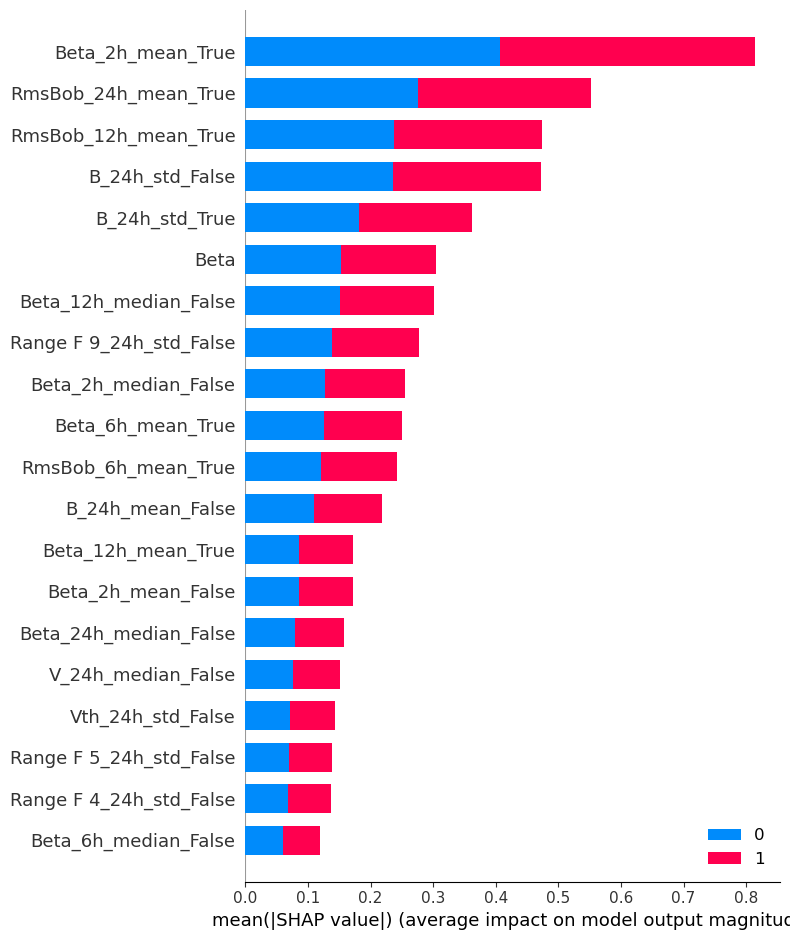

In [26]:
import shap
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X.values, plot_type='bar', class_names=cat.classes_, feature_names=X.columns)

In [28]:
2*[1]

[1, 1]